<a href="https://colab.research.google.com/github/lindatey/melanoma_detector_with_cnn/blob/main/lindatey_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array

!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-yauoffo2
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-yauoffo2
  Resolved https://github.com/tensorflow/docs to commit af33301a434ea70e104865b9d2e93e230494c1cb
  Preparing metadata (setup.py) ... done


In [3]:
import statistics
import pickle

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

images_folder = '/content/gdrive/MyDrive/Colab Notebooks/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(f"{images_folder}/Train")
data_dir_test = pathlib.Path(f'{images_folder}/Test')
model_result = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Melanoma Detection Assignment/models')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writing the dataset

train_ds,val_ds  = tf.keras.utils.image_dataset_from_directory(
                         data_dir_train
                        ,labels='inferred'
                        #,label_mode = 'categorical'
                        ,seed = 123,image_size=(img_height,img_width)
                        ,batch_size=batch_size
                        ,validation_split = 0.2
                        ,subset='both')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float

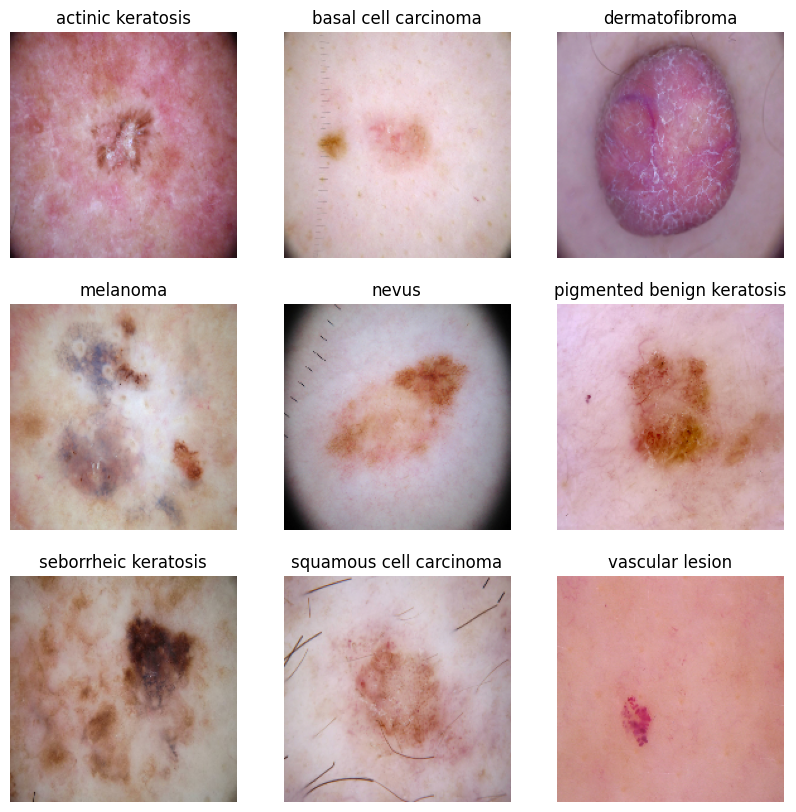

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
def load_images(dataset):
  class_names = dataset.class_names
  plt.figure(figsize=(10, 10))
  for i in range(len(class_names)):
      filtered_ds = dataset.filter(lambda x, l: tf.math.equal(l[0], i))
      print(filtered_ds)
      for image, label in filtered_ds.take(1):
          ax = plt.subplot(3, 3, i+1)
          plt.imshow(image[0].numpy().astype('uint8'))
          plt.title(class_names[label.numpy()[0]])
          plt.axis('off')

load_images(train_ds)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
### Your code goes here
def rescaling_image(dataset):
  normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  normalized_ds = dataset.map(lambda x, y: (normalization_layer(x), y))

  return normalized_ds


In [12]:
# Notice the pixel values are now in `[0,1]`.
normalized_train_ds = rescaling_image(train_ds)
normalized_val_ds = rescaling_image(val_ds)

AUTOTUNE = tf.data.experimental.AUTOTUNE
normalized_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
#normalized_train_ds.unbatch()
#normalized_val_ds.unbatch()
#train_ds.unbatch()
#val_ds.unbatch()

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function

In [15]:
def count_by_class(class_names,dataset):
  class_count = {class_name: 0 for class_name in class_names}

  for _, labels in dataset:
      for label in labels.numpy():
          class_name = class_names[label]
          class_count[class_name] += 1
  return class_count

def get_shape(dataset):
   ds = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
   element_spec = ds.element_spec
   return element_spec[0].shape

def get_optimizer(dataset):
  STEPS_PER_EPOCH = img_height / batch_size
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps= STEPS_PER_EPOCH *100,
    decay_rate=1,
    staircase=False)
  return tf.keras.optimizers.Adam(lr_schedule)

def build_model(_layers, dataset):
  model = tf.keras.Sequential(_layers)

  model.compile(
     optimizer= get_optimizer(dataset),
     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

  model.build(input_shape= get_shape(dataset))

  return model

def plot_history(model_name, _history,_epochs):
  plt.figure(figsize=(8, 5))

  acc = _history.history['accuracy']
  val_acc = _history.history['val_accuracy']
  loss = _history.history['loss']
  val_loss = _history.history['val_loss']

  acc_std_dev = statistics.pstdev(acc)
  loss_std_dev = statistics.pstdev(loss)

  acc_min = min([min(acc),min(val_acc)])-acc_std_dev
  acc_max = max([max(acc),max(val_acc)])+acc_std_dev

  loss_min = min([min(loss),min(val_loss)])-loss_std_dev
  loss_max = max([max(loss),max(val_loss)])+loss_std_dev

  acc_range = [acc_min,acc_max]
  loss_range = [loss_min, loss_max]

  plt.subplot(1, 2, 1)
  plotter = tfdocs.plots.HistoryPlotter(metric='accuracy')
  plotter.plot({model_name:_history})
  plt.ylim(acc_range)

  plt.subplot(1, 2, 2)
  plotter = tfdocs.plots.HistoryPlotter(metric='loss')
  plotter.plot({model_name:_history})
  plt.ylim(loss_range)

def build_observe(_layers,train_dataset, val_dataset, _epochs, model_name='base'):
    model = build_model(_layers=_layers, dataset=train_dataset)

    print(model.summary())

    _history = model.fit(train_dataset, validation_data=val_dataset, epochs=_epochs)

    plot_history(model_name,_history,_epochs)

    save_model(model_name=f'{model_name}',model=model,model_history=_history)

    return model,_history, max(_history.history['accuracy'])

def save_model(model_name,model,model_history,folder=model_result):
  # Save the model weights to a file
  model.save_weights(f'{folder}/{model_name}.h5')
  with open(f'{folder}/{model_name}_history.pkl', 'wb') as file:
    pickle.dump(model_history.history, file)

def load_model(folder,model_name,model):
  model.load_weights(f'{folder}/{model_name}.h5')
  with open(f'{folder}/{model_name}.pkl', 'rb') as file:
    history = pickle.load(file)
  return model,history

def load_history(folder,model_name,model):
    with open(f'{folder}/{model_name}.pkl', 'rb') as file:
      return pickle.load(file)


In [16]:
EPOCHS = 20

In [17]:
layer = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names))
    ]
model = build_model(
    _layers = layer
    ,dataset = normalized_train_ds
)

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 97200)             0         
                                                                 
 dense (Dense)               (None, 9)                 874809    
                                                                 
Total params: 874809 (3.34 MB)
Trainable params: 874809 (3.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train the model

#### Model 1 - Base simplified Model

In [19]:
_history = model.fit(normalized_train_ds, validation_data=normalized_val_ds, epochs=EPOCHS)

Epoch 1/20
56/56 [==============================] - 113s 2s/step - loss: 39.4344 - accuracy: 0.1752 - val_loss: 9.8606 - val_accuracy: 0.2103
Epoch 2/20
56/56 [==============================] - 0s 7ms/step - loss: 11.7354 - accuracy: 0.2321 - val_loss: 10.6159 - val_accuracy: 0.2752
Epoch 3/20
56/56 [==============================] - 0s 7ms/step - loss: 11.0345 - accuracy: 0.2812 - val_loss: 12.4206 - val_accuracy: 0.1253
Epoch 4/20
56/56 [==============================] - 0s 7ms/step - loss: 8.7774 - accuracy: 0.2913 - val_loss: 4.8046 - val_accuracy: 0.1902
Epoch 5/20
56/56 [==============================] - 0s 7ms/step - loss: 6.2122 - accuracy: 0.3292 - val_loss: 7.2277 - val_accuracy: 0.3154
Epoch 6/20
56/56 [==============================] - 0s 7ms/step - loss: 8.0455 - accuracy: 0.3047 - val_loss: 4.0975 - val_accuracy: 0.3445
Epoch 7/20
56/56 [==============================] - 0s 7ms/step - loss: 4.5665 - accuracy: 0.3488 - val_loss: 5.9743 - val_accuracy: 0.2573
Epoch 8/20
56/

### Visualizing training results

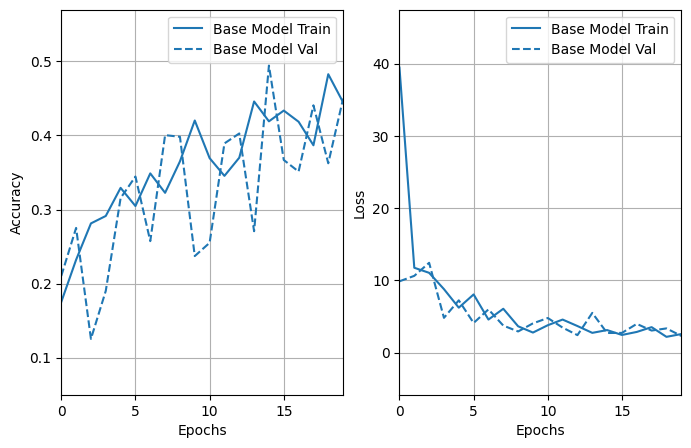

In [20]:
plot_history('Base Model',_history,EPOCHS)


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The overlaps between training and validation curves indicates the result are not too far from each other. However, the low accuracy shows sign of underfitting and it is most probably due to over simplication of the model.

In [21]:
save_model('base',model,_history)

### Todo:
### Create the model, compile and train the model


In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#### Model 2 - Augmented Simplified Model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 flatten_1 (Flatten)         (None, 97200)             0         
                                                                 
 dense_1 (Dense)             (None, 9)                 874809    
                                                                 
Total params: 874809 (3.34 MB)
Trainable params: 874809 (3.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
56/56 [==============================] - 2s 13ms/step - loss: 42.4693 - accuracy: 0.1635 - val_loss: 19.0220 - val_accuracy: 0.2349
Epoch 2/20
56/56 [==============================] - 1s 10ms/step - loss: 10.7465 - accuracy: 0.2416 - val_loss: 15.3364 - val_accuracy

(<keras.src.engine.sequential.Sequential at 0x7cb5adfdfe20>,
 0.3922991156578064)

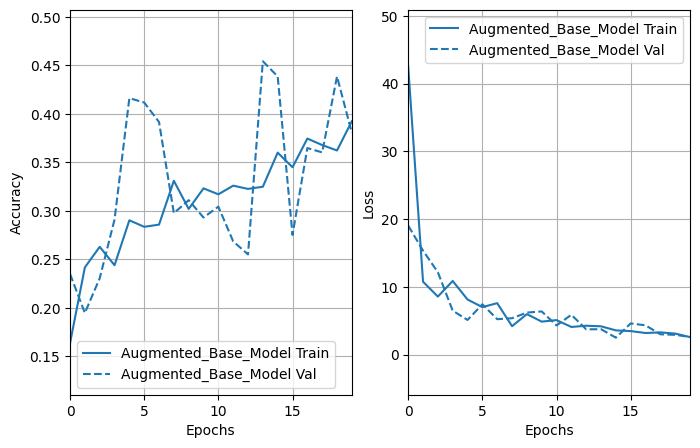

In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
layer= [
    data_augmentation,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names))
  ]
build_observe(_layers=layer
              ,train_dataset = normalized_train_ds
              , val_dataset=normalized_val_ds
              ,_epochs=EPOCHS
              ,model_name='augmented_base_model')



By adding Data Augmentation in the model, the gap between train dataset and val dataset accuracy has reduced significantly. Validation curve seems to be instable and the peak and the descend is significant. The low accuracy indicates the model is underfit due to over simplicity.

### Compiling the model

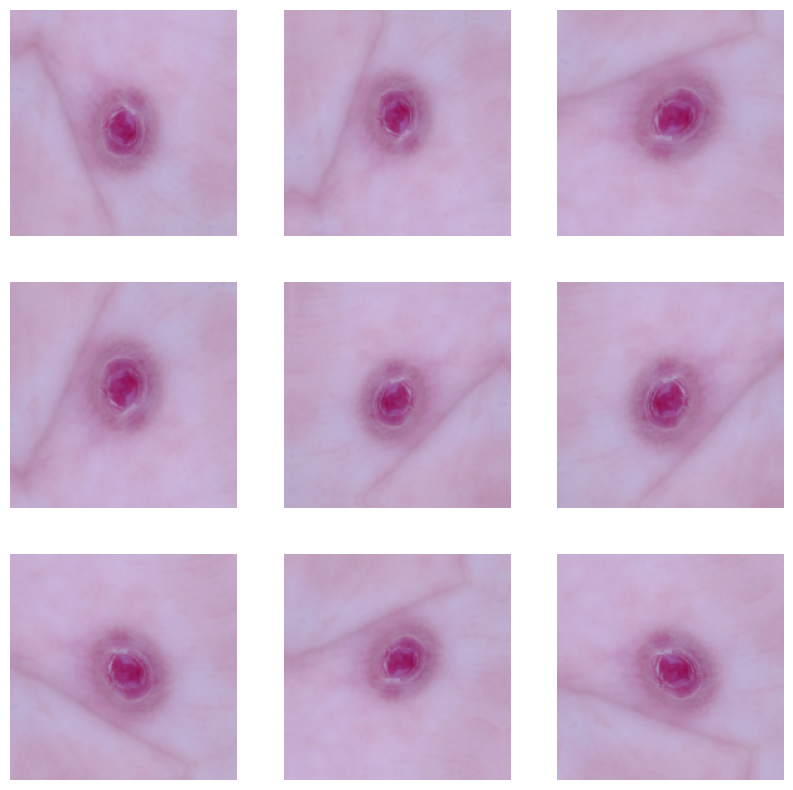

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Training the model

#### Model 3 - Adding complexity to the model - 3X2D_3MP_1FL_1D

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)      

(<keras.src.engine.sequential.Sequential at 0x7cb5bc72ee30>,
 0.6194196343421936)

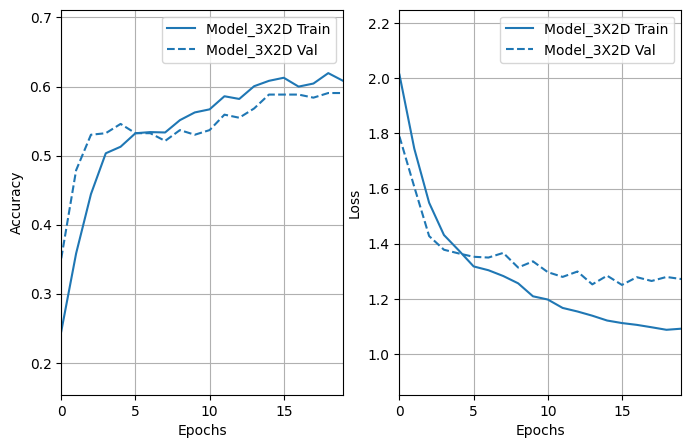

In [25]:
## Your code goes here
layer= [
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(len(class_names))
  ]
build_observe(_layers=layer
              ,train_dataset = normalized_train_ds
              , val_dataset=normalized_val_ds
              ,_epochs=EPOCHS
              ,model_name='model_3X2D')



### Visualizing the results

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- By adding 3 convulational layers to the model, accuracy has increased and no overfitting nor underfitting sighted.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#####Distribution for Train dataset

<Axes: xlabel='Class'>

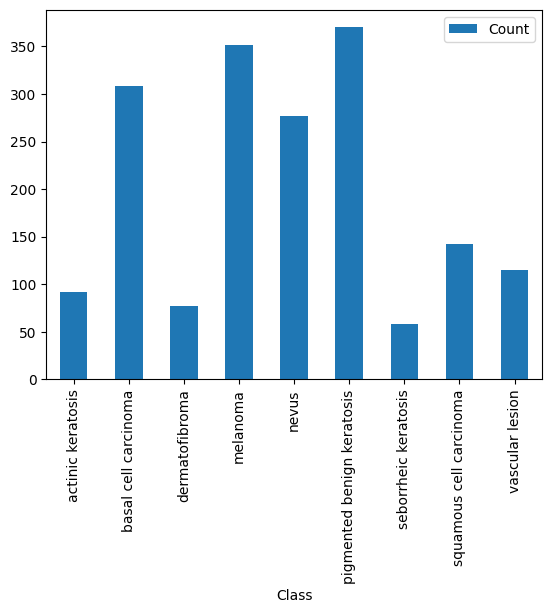

In [27]:
cnt= count_by_class(class_names, train_ds)
df = pd.DataFrame(list(cnt.items()), columns=['Class', 'Count'])
df.plot.bar(x='Class')

#####Distribution for Valuation dataset

<Axes: xlabel='Class'>

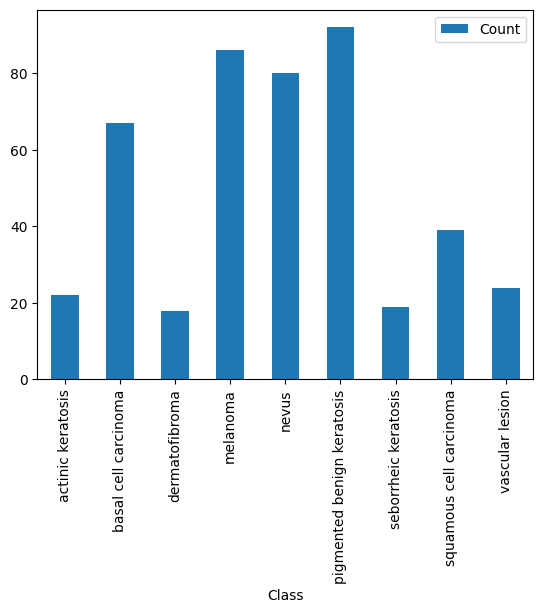

In [28]:
cnt= count_by_class(class_names, val_ds)
df = pd.DataFrame(list(cnt.items()), columns=['Class', 'Count'])
df.plot.bar(x='Class')

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - A: Seborrheic Keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
#### - A: Pigmented Benign Keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset=f'{images_folder}/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB5366DBDC0>: 100%|██████████| 500/500 [00:22<00:00, 21.86 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB536797E80>: 100%|██████████| 500/500 [00:29<00:00, 16.90 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB5C54760B0>: 100%|██████████| 500/500 [00:25<00:00, 19.78 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7CB536523CA0>: 100%|██████████| 500/500 [01:24<00:00,  5.91 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CB5365891B0>: 100%|██████████| 500/500 [01:26<00:00,  5.77 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB5C54760B0>: 100%|██████████| 500/500 [00:20<00:00, 24.97 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7CB536699300>: 100%|██████████| 500/500 [00:45<00:00, 11.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB5C4044F10>: 100%|██████████| 500/500 [00:18<00:00, 27.15 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB5366F89A0>: 100%|██████████| 500/500 [00:19<00:00, 25.75 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
import os
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list)


4500

In [33]:
original_path_list = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
original_list = [x.split('/')[-2] for x in original_path_list]
original_list[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [34]:
dict_new = dict(zip(original_path_list, original_list))
original_df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/cnn as...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/cnn as...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/cnn as...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/cnn as...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/cnn as...,actinic keratosis


In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [37]:
new_df = original_df.append(df2)

<ipython-input-37-2ade1842133b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [38]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [39]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset & validation dataset

In [41]:
#data_dir_train= data_dir_train
train_ds,val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'both',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [42]:
normalized_train_ds = rescaling_image(train_ds)
normalized_val_ds = rescaling_image(val_ds)

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
normalized_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_37 (Dropout)        (None, 43, 43, 64)      

(<keras.src.engine.sequential.Sequential at 0x7cb5adfdcbb0>,
 0.7114243507385254)

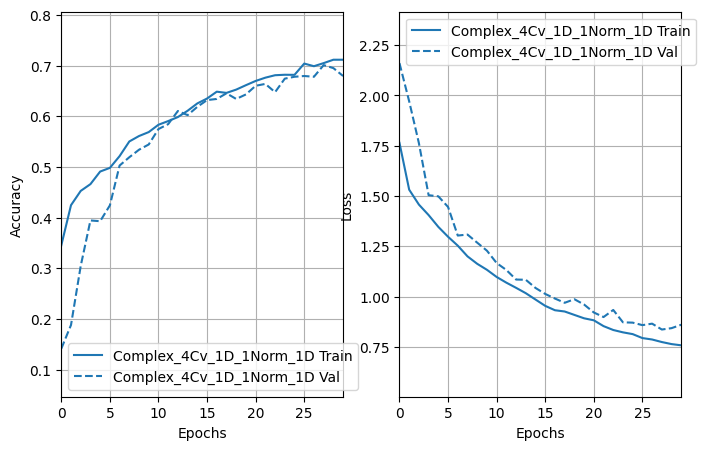

In [54]:
EPOCHS = 30
class_names = train_ds.class_names
layer= [
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    #layers.Dense(128),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(len(class_names))
  ]
build_observe(_layers=layer
              ,train_dataset = normalized_train_ds
              , val_dataset=normalized_val_ds
              ,_epochs=EPOCHS
              ,model_name='complex_4CV_1D_1NORM_1D')


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_47 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_35 (Dropout)        (None, 43, 43, 64)      

(<keras.src.engine.sequential.Sequential at 0x7cb50872c250>,
 0.7373887300491333)

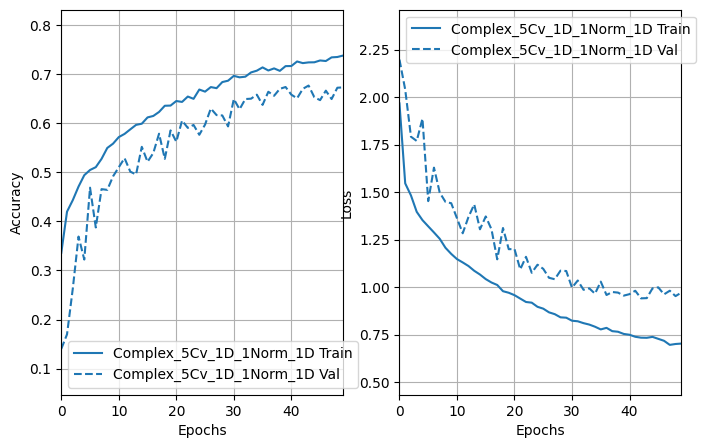

In [53]:
EPOCHS = 50
class_names = train_ds.class_names
layer= [
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Dense(128),
    layers.BatchNormalization(),

    layers.Dense(128),

    layers.Flatten(),
    layers.Dense(len(class_names))
  ]
build_observe(_layers=layer
              ,train_dataset = normalized_train_ds
              , val_dataset=normalized_val_ds
              ,_epochs=EPOCHS
              ,model_name='complex_5CV_1D_1NORM_1D')


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Yes, class rebalance helped to fix the underfitting problem. The validation and training curve are now running with consistent gap against each other.

The accuracy has also increased from 40% in earlier runs compared to after class rebalance.